# Power traces analysis

This is just a test before applying on the chips. It uses python rather than C.

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from keras.preprocessing.sequence import TimeseriesGenerator
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
import pickle

Using TensorFlow backend.


## 1. Data Preprocessing

**Read data from csv file**: get data.

In [2]:
file_path = "../dataset/grafana_data_export.csv"

data = pd.read_csv(file_path, \
                   error_bad_lines=False, warn_bad_lines=False, \
                   sep=';', thousands=',', \
                   dtype={'Series': 'object', 'Value': 'float'}, \
                   parse_dates=['Time'])

display(data.head())
print("Data shape: {0}".format(data.shape))

,Series,Time,Value
0,Black and white printer,2018-10-27 16:44:25,3.31
1,Black and white printer,2018-10-27 16:44:25,3.31
2,Black and white printer,2018-10-27 16:44:26,4.29
3,Black and white printer,2018-10-27 16:44:26,4.29
4,Black and white printer,2018-10-27 16:44:27,3.77


Data shape: (1940080, 3)


In [3]:
data.dtypes

Series            object
Time      datetime64[ns]
Value            float64
dtype: object

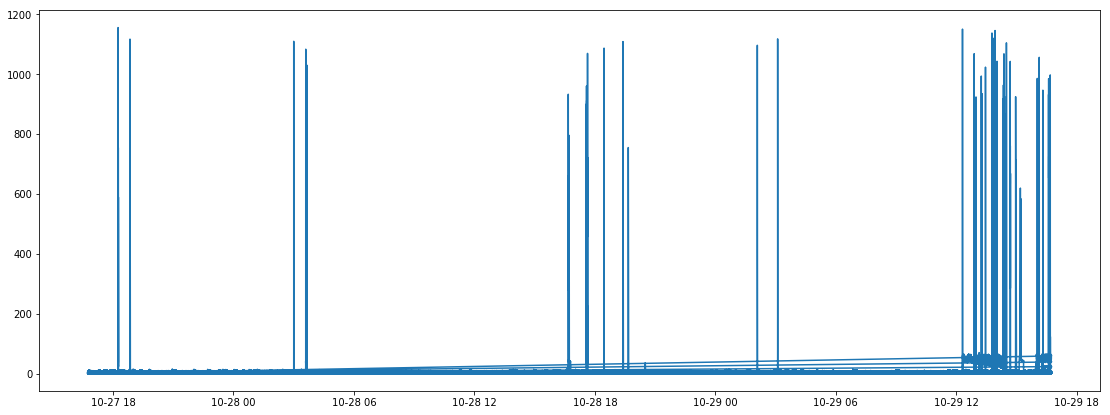

In [4]:
plt.figure(figsize=(19,7))
plt.plot(data['Time'], data['Value'])
plt.show()

**Label Encoding**

In [44]:
encoder = LabelEncoder()
data['Series'] = encoder.fit_transform(data['Series'])

**Partitioning**: partition the whole power traces into small traces with a duration of *k* seconds. The label of these small traces is the corresponding value in Series.

In [ ]:
'''
def data_partition(time, series, value, k, do_print=False):
    """ Partition data
    
    Args:
        time: (np.array) the 'Time' column in data
        series: (np.array) the 'Series' column in data
        value: (np.array) the 'Value' column in data
        k: (int) indicate the length of small time interval
        do_print: (boolean) print current status or not.
    
    Returns:
        cnt: (int) the number of found valid small traces
        part_time: (np.array) the start time of the corresponding small trace partition
        part_series: (np.array) label of the corresponding trace
        part_value: (2d np.array) the power traces
    """
    n = len(time)
    part_time = np.zeros(n, dtype='datetime64[s]')
    part_series = np.zeros(n, dtype='object')
    part_value =  np.zeros([n, k], dtype='float')
    last_time = time[0] - np.timedelta64(1, 's')
    
    cnt = 0 # count of found valid small traces
    for i in range(n):
        # print current status
        if(do_print and i%50000 == 0):
            print("Current iteration: {0}".format(i))
        # avoid repetition
        if time[i] - last_time == np.timedelta64(0, 'ns'):
            continue
        last_time = time[i]
        
        # get current partition
        cur_label = series[i]
        cur_part = np.full(k, np.nan)
        for j in range(i, n):
            idx = int((time[j] - time[i]) / np.timedelta64(1, 's'))
            if(series[j] != cur_label or idx >= k or idx < 0):
                break
            cur_part[idx] = value[j]
            
        if(len(cur_part) < k): # ignore too short power traces
            continue;
        
        # do interpolation for missing values
        for j in range(len(cur_part)): 
            if(np.isnan(cur_part[j])):
                cur_part[j] = cur_part[j - 1]
        
        # save the partitioned data
        part_time[cnt] = time[i]
        part_series[cnt] = cur_label
        part_value[cnt] = cur_part
        cnt += 1;
    
    return cnt, part_time[:cnt], part_series[:cnt], part_value[:cnt]

k = 120
data_time, data_series, data_value = pd.np.array(data['Time']), pd.np.array(data['Series']), pd.np.array(data['Value'])

cnt, part_time, part_series, part_value = data_partition(data_time, data_series, data_value, k, do_print=True)
'''

In [7]:
"""
data_part_df = pd.DataFrame([part_time, part_series, part_value])

data_part_df = data_part_df.T
data_part_df.columns = ["time", "series", "partition_values"]

data_part_df.head()
"""

In [72]:
data_gen = TimeseriesGenerator(np.array(data['Value']), 
                               np.array(data['Series']),
                               length=60, sampling_rate=1, 
                               batch_size=1)

print("Length of datasets: {0}".format(len(data_gen)))
print("Length of data sample: {0}".format(len(data_gen[0][0][0])))

Length of datasets: 1940020
Length of data sample: 60


(**\*Save data in file / Load data from file**: Reduce unnecessary computation.)

In [ ]:
"""
dataFile = "data"

with open(dataFile, 'wb') as outfile:
    pickle.dump([part_time, part_series, part_value], outfile)
    
with open(dataFile, 'rb') as infile:
    part_time, part_series, part_value = pickle.load(infile)
"""

In [73]:
dataFile = "data_gen"

In [74]:
with open(dataFile, 'wb') as outfile:
    pickle.dump(data_gen, outfile)

In [75]:
with open(dataFile, 'rb') as infile:
    data_gen = pickle.load(infile)

**FFT**

In [5]:
fft_part_value_real, fft_part_value_imag = np.empty(part_value.shape), np.empty(part_value.shape)
 
for i in range(len(part_value)):
    sp = np.fft.fft(part_value[i, :])
    fft_part_value_real[i, :] = sp.real
    fft_part_value_imag[i, :] = sp.imag

**Generating training/testing data set**: train test split

In [76]:
X, y = part_value, part_series

In [78]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=10)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=76)
print("{0} train + {1} validation + {2} test".format(len(X_train), len(X_val), len(X_test)))

1021792 train + 255449 validation + 319311 test


**Data Visualization**: Visualize different types of signals.

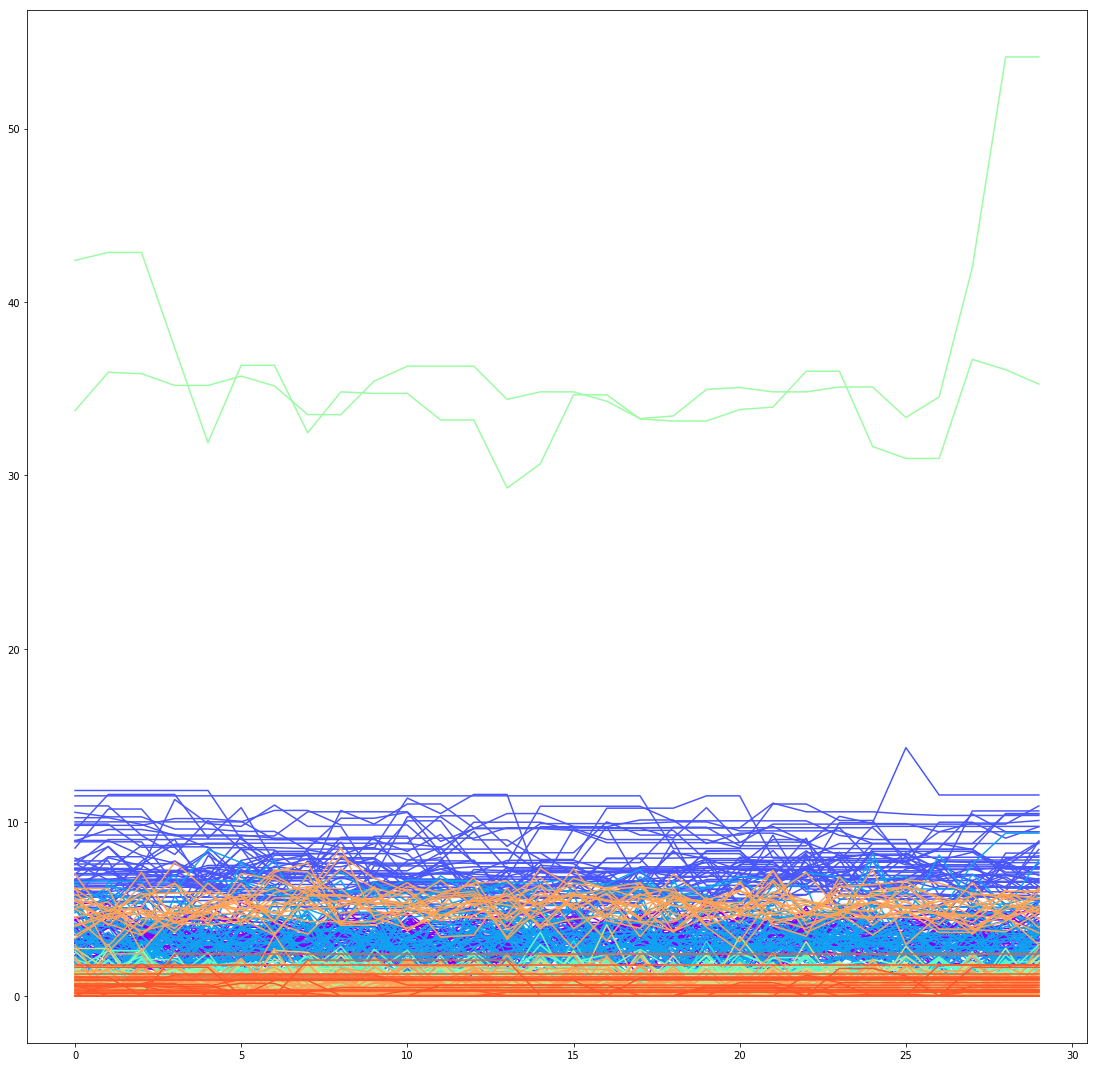

In [110]:
color = iter(plt.cm.rainbow(np.linspace(0,1,10)))

plt.figure(figsize=(19,19))
t = np.arange(30)
freq = np.fft.fftfreq(t.shape[-1])
for k in range(9):
    c = next(color)
    for sample in X_train[np.where(y_train == k)[0][:50]]:
        plt.plot(sample, c=c)
        #sp = np.fft.fft(sample)
        #freq = np.fft.fftfreq(t.shape[-1])
        #plt.plot(freq, sample.real, freq, sample.imag, c=c)

plt.show()

## 2. Try different classification models

Followed the document [Classifier comparison](https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html) and [Confusion matrix](https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py) on scikit learn site.

In [80]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [81]:
names = ["Nearest Neighbors", 
         "Random Forest", 
         "Neural Net",
         "Voting"]

classifiers = [
    KNeighborsClassifier(3),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1),
    VotingClassifier(estimators=[
        ('knn', KNeighborsClassifier(3)), 
        ('rf', RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1)), 
        ('nn', MLPClassifier(alpha=1))], voting='hard')
]

In [82]:
train_size = 10000
test_size = 1000

Nearest Neighbors:
accuracy score: 0.501
Confusion matrix, without normalization
[[ 83   0   3   0   0   1   0   0   0]
 [  0  38   0   0   0   0   0   1   0]
 [ 75   0  11   0   0   0   0   7   0]
 [  0   0   0  32   0  19  50   3   1]
 [  0   0   0   4  77   2  18   2   0]
 [  0   0   0  28   0  11  34   2   0]
 [  0   0   0  65  12  51 133  12   1]
 [  0   1   0  35   4  15  52 116   0]
 [  0   0   0   0   1   0   0   0   0]]


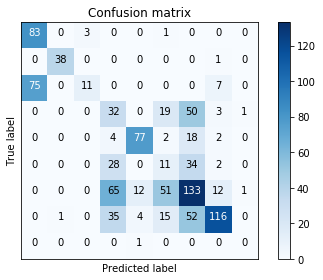

Random Forest:
accuracy score: 0.533
Confusion matrix, without normalization
[[ 67   0  18   0   0   0   0   2   0]
 [  0  35   0   0   0   0   0   4   0]
 [ 47   0  37   0   1   0   0   8   0]
 [  0   0   0   0   0   0 105   0   0]
 [  0   0   0   0  11   0  92   0   0]
 [  0   0   0   0   0   1  74   0   0]
 [  0   0   0   0   4   0 270   0   0]
 [  0   0   0   0   0   0 111 112   0]
 [  0   0   0   0   0   0   1   0   0]]


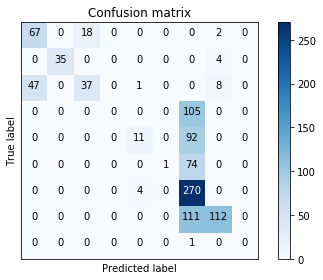

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Neural Net:
accuracy score: 0.624
Confusion matrix, without normalization
[[ 75   0  12   0   0   0   0   0   0]
 [  0  35   0   0   0   0   0   4   0]
 [ 37   0  49   0   0   0   0   7   0]
 [  0   0   0   7   1   0  97   0   0]
 [  0   0   0   0  94   0   9   0   0]
 [  0   0   0   1   0   1  73   0   0]
 [  0   1   2   8  10   1 252   0   0]
 [  0   1   0   0  11   0 100 111   0]
 [  0   0   0   0   1   0   0   0   0]]


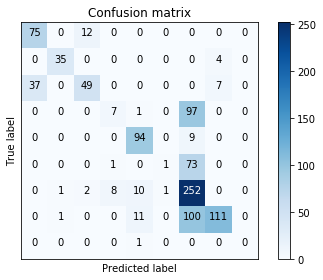

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Voting:
accuracy score: 0.604
Confusion matrix, without normalization
[[ 82   0   4   0   0   1   0   0   0]
 [  0  38   0   0   0   0   0   1   0]
 [ 59   0  26   0   1   0   0   7   0]
 [  0   0   0   7   0   2  96   0   0]
 [  0   0   0   1  82   0  20   0   0]
 [  0   0   0   1   0   1  73   0   0]
 [  1   0   1   4  10   1 257   0   0]
 [  0   1   0   3   3   0 105 111   0]
 [  0   0   0   0   1   0   0   0   0]]


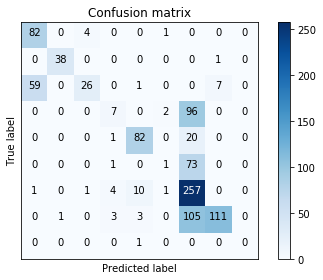

In [83]:
for name, clf in zip(names, classifiers):
    clf.fit(X_train[:train_size, :], y_train[:train_size])
    y_pred = clf.predict(X_test[:test_size, :])
    
    score = accuracy_score(y_test[:test_size], y_pred)
    
    print("{0}:".format(name))
    print("accuracy score: {0}".format(score))
    
    cnf_matrix = confusion_matrix(y_test[:test_size], y_pred)
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=[])
    plt.show()

## 3. Using Neural Network

In [104]:
import keras
from keras.models import Sequential
from keras.models import Input, Model
from keras.layers import Dense, Dropout, Activation, Embedding, LSTM, GRU
from keras.optimizers import SGD, RMSprop, Adam
from tcn import TCN

**Get new nn_y_train and nn_y_test**: To meet the output layer requirement of DNN.

In [91]:
nn_y_train = np.zeros([len(y_train), len(encoder.classes_)])
nn_y_test = np.zeros([len(y_test), len(encoder.classes_)])

In [96]:
train_size = 10000
val_size = 100
test_size = 100

X_train = np.reshape(X_train, (X_train.shape[0],
                              X_train.shape[1],
                              1))
X_test = np.reshape(X_test, (X_test.shape[0],
                              X_test.shape[1],
                              1))

**DNN**

In [107]:
model = Sequential()

model.add(Dense(1000, activation='relu', input_dim=30))
model.add(Dense(9, activation='softmax'))

adam = Adam()
model.compile(loss='mse',
              optimizer=adam,
              metrics=['accuracy'])

history = m.fit(X_train[:train_size], nn_y_train[:train_size], 
                epochs=10, batch_size=200, validation_split=0.2)

Train on 1600 samples, validate on 400 samples
Epoch 1/10
1600/1600 [==============================] - 16s 10ms/step - loss: 0.0123 - acc: 0.1244 - val_loss: 0.0123 - val_acc: 0.0850
Epoch 2/10
1600/1600 [==============================] - 14s 9ms/step - loss: 0.0123 - acc: 0.1106 - val_loss: 0.0123 - val_acc: 0.1200
Epoch 3/10
1600/1600 [==============================] - 15s 9ms/step - loss: 0.0123 - acc: 0.1262 - val_loss: 0.0123 - val_acc: 0.0875
Epoch 4/10
1600/1600 [==============================] - 15s 10ms/step - loss: 0.0123 - acc: 0.1125 - val_loss: 0.0123 - val_acc: 0.0875
Epoch 5/10
1600/1600 [==============================] - 15s 9ms/step - loss: 0.0123 - acc: 0.1206 - val_loss: 0.0123 - val_acc: 0.0875
Epoch 6/10
1600/1600 [==============================] - 14s 9ms/step - loss: 0.0123 - acc: 0.1231 - val_loss: 0.0123 - val_acc: 0.0750
Epoch 7/10
1600/1600 [==============================] - 15s 10ms/step - loss: 0.0123 - acc: 0.1156 - val_loss: 0.0123 - val_acc: 0.0825
Epoch

ValueError: Error when checking input: expected dense_29_input to have 2 dimensions, but got array with shape (100, 30, 1)

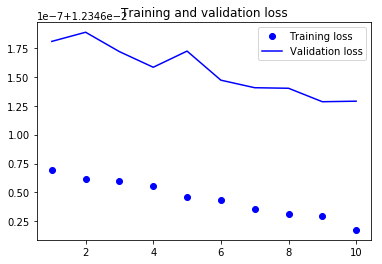

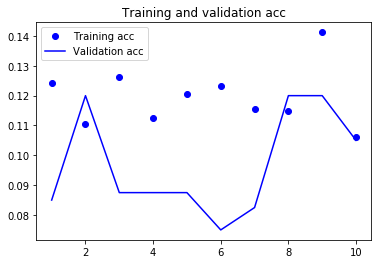

In [108]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

acc = history.history['acc']
val_acc = history.history['val_acc']

epochs = range(1, len(acc) + 1)

plt.figure()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation acc')
plt.legend()

plt.show()

**TCN**

In [97]:
batch_size, timesteps, input_dim = None, 30, 1

i = Input(batch_shape=(batch_size, timesteps, input_dim))

o = TCN(return_sequences=False,
        use_skip_connections=True,
        nb_stacks=2,
        dilations=[2 ** i for i in range(9)])(i)  # The TCN layers are here.
o = Dense(100, activation='relu')(o)
o = Dense(9, activation='softmax')(o)

m = Model(inputs=[i], outputs=[o])
m.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

history = m.fit(X_train[:train_size], nn_y_train[:train_size], epochs=10, validation_split=0.2)

Train on 1600 samples, validate on 400 samples
Epoch 1/10
1600/1600 [==============================] - 21s 13ms/step - loss: 0.0127 - acc: 0.1206 - val_loss: 0.0124 - val_acc: 0.0475
Epoch 2/10
1600/1600 [==============================] - 16s 10ms/step - loss: 0.0124 - acc: 0.0894 - val_loss: 0.0124 - val_acc: 0.0500
Epoch 3/10
1600/1600 [==============================] - 17s 11ms/step - loss: 0.0124 - acc: 0.0931 - val_loss: 0.0123 - val_acc: 0.0800
Epoch 4/10
1600/1600 [==============================] - 17s 11ms/step - loss: 0.0123 - acc: 0.0944 - val_loss: 0.0123 - val_acc: 0.0750
Epoch 5/10
1600/1600 [==============================] - 17s 10ms/step - loss: 0.0123 - acc: 0.0975 - val_loss: 0.0123 - val_acc: 0.1100
Epoch 6/10
1600/1600 [==============================] - 17s 11ms/step - loss: 0.0123 - acc: 0.0969 - val_loss: 0.0123 - val_acc: 0.0775
Epoch 7/10
1600/1600 [==============================] - 19s 12ms/step - loss: 0.0123 - acc: 0.1100 - val_loss: 0.0123 - val_acc: 0.0925
E

In [88]:
score = m.evaluate(X_test[:test_size], nn_y_test[:test_size])
score

100/100 [==============================] - 0s 2ms/step


[0.00019583692657761275, 0.04]

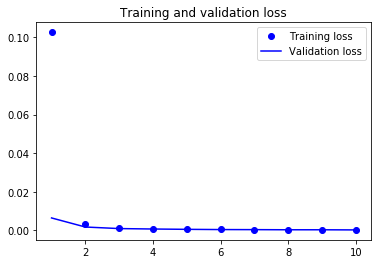

In [89]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [66]:
################## TEST SECTION ###################
